/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.3613 - mae: 0.3129 - val_loss: 0.1700 - val_mae: 0.1295
Epoch 2/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2456 - mae: 0.2212 - val_loss: 0.1659 - val_mae: 0.1295
Epoch 3/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2214 - mae: 0.1991 - val_loss: 0.1536 - val_mae: 0.0909
Epoch 4/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1967 - mae: 0.1834 - val_loss: 0.1539 - val_mae: 0.0982
Epoch 5/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2011 - mae: 0.1748 - val_loss: 0.1520 - val_mae: 0.0960
Epoch 6/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1894 - mae: 0.1719 - val_loss: 0.1510 - val_mae: 0.0953
Epoch 7/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1880 - mae: 0.1643 - val_loss: 0.1474 - val_mae: 0.0847
Epoch 8/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1862 - mae: 0.1577 - val_loss: 0.1473 - val_mae: 0.0912
Epoch 9/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1755 

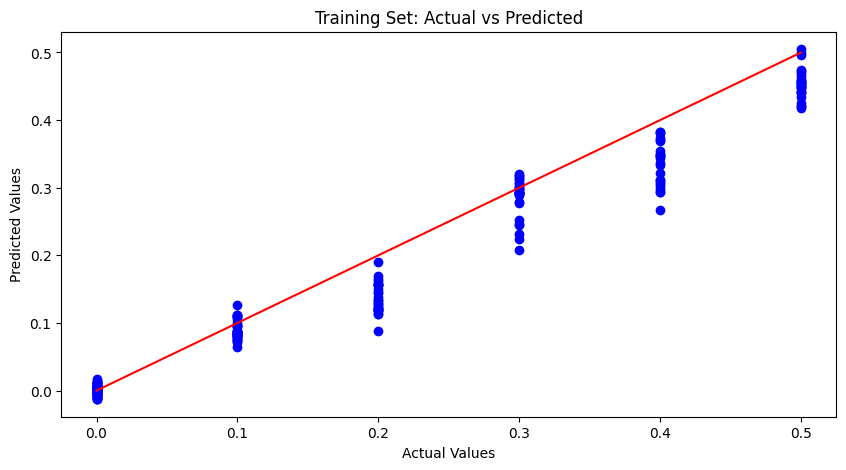

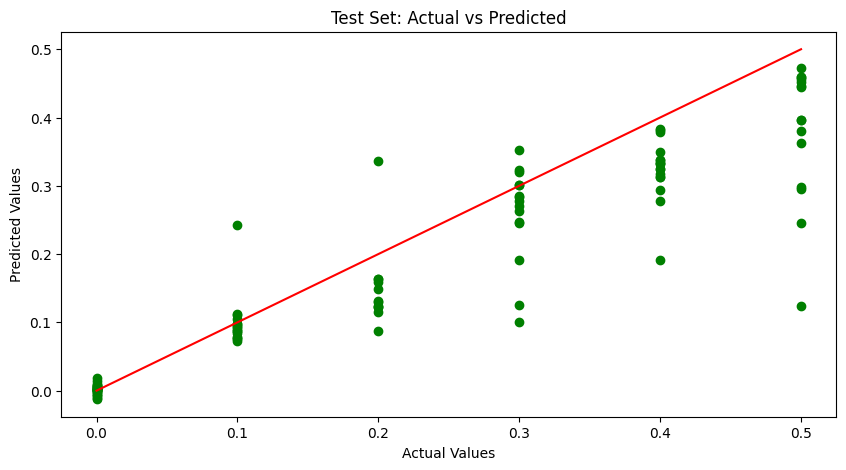

ValueError: continuous format is not supported

In [ ]:
# Install necessary packages
# !pip install keras tensorflow scikit-learn matplotlib pandas

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/skuma21.csv', header=0).values

# Partition the data
np.random.seed(1234)
ind = np.random.choice([1, 2], size=data.shape[0], p=[0.7, 0.3])
training = data[ind == 1, 1:11]
test = data[ind == 2, 1:11]
training_target = data[ind == 1, 0]
test_target = data[ind == 2, 0]

# Normalize the data
mean = training.mean(axis=0)
std = training.std(axis=0)
training = (training - mean) / std
test = (test - mean) / std

# Define a function to build and compile the model
def build_model(dense_units1, dense_units2, dense_units3, dropout_rate1, dropout_rate2, dropout_rate3, learning_rate):
    model = models.Sequential()
    model.add(layers.Dense(units=dense_units1, activation='relu', input_shape=(10,), kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(rate=dropout_rate1))
    model.add(layers.Dense(units=dense_units2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(rate=dropout_rate2))
    model.add(layers.Dense(units=dense_units3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(rate=dropout_rate3))
    model.add(layers.Dense(units=1, activation='linear'))

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        metrics=['mae']
    )

    return model

# Set hyperparameters
dense_units1 = 128  # Increased number of units
dense_units2 = 64
dense_units3 = 32
dropout_rate1 = 0.4
dropout_rate2 = 0.2
dropout_rate3 = 0.1
learning_rate = 0.001  # Lower learning rate

# Build the model
model = build_model(dense_units1, dense_units2, dense_units3, dropout_rate1, dropout_rate2, dropout_rate3, learning_rate)

# Callbacks for early stopping and model checkpoint
#callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
#callback_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True)
# Callbacks for early stopping and model checkpoint
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)
callback_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', save_best_only=True) # Changed .h5 to .keras
# Fit the model
history = model.fit(
    training, training_target,
    epochs=1500,
    batch_size=64,
    validation_split=0.2,
    callbacks=[callback_early_stopping, callback_model_checkpoint],
    verbose=1
)

# Load the best model
model = tf.keras.models.load_model("best_model.keras") # Changed file name to best_model.keras

# Evaluate the model on the test set
evaluation = model.evaluate(test, test_target)
test_predictions = model.predict(test).flatten()

# Evaluate the model on the training set
train_predictions = model.predict(training).flatten()

# Calculate RMSEC (Root Mean Squared Error of Calibration)
rmsec = np.sqrt(mean_squared_error(training_target, train_predictions))

# Calculate RMSEP (Root Mean Squared Error of Prediction)
rmsep = np.sqrt(mean_squared_error(test_target, test_predictions))

# Calculate MAE (Mean Absolute Error)
mae_train = mean_absolute_error(training_target, train_predictions)
mae_test = mean_absolute_error(test_target, test_predictions)

# Calculate R^2 (Coefficient of Determination) for training and test sets
r_squared_train = 1 - (np.sum((training_target - train_predictions) ** 2) / np.sum((training_target - np.mean(training_target)) ** 2))
r_squared_test = 1 - (np.sum((test_target - test_predictions) ** 2) / np.sum((test_target - np.mean(test_target)) ** 2))

# Calculate AUC and plot ROC curve for training set
#auc_train = roc_auc_score(training_target, train_predictions)
#auc_test = roc_auc_score(test_target, test_predictions)

# Print the metrics
print("Evaluation Metrics for Training Set:")
print(f"RMSEC: {rmsec}")
print(f"MAE: {mae_train}")
print(f"R^2: {r_squared_train}")
#print(f"AUC: {auc_train}")

print("\nEvaluation Metrics for Test Set:")
print(f"RMSEP: {rmsep}")
print(f"MAE: {mae_test}")
print(f"R^2: {r_squared_test}")
#print(f"AUC: {auc_test}")

# Plot Actual vs Predicted for training set
plt.figure(figsize=(10, 5))
plt.scatter(training_target, train_predictions, color='blue', label='Train')
plt.plot([min(training_target), max(training_target)], [min(training_target), max(training_target)], color='red')
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Plot Actual vs Predicted for test set
plt.figure(figsize=(10, 5))
plt.scatter(test_target, test_predictions, color='green', label='Test')
plt.plot([min(test_target), max(test_target)], [min(test_target), max(test_target)], color='red')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Plot ROC curve for training set
fpr_train, tpr_train, _ = roc_curve(training_target, train_predictions)
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train AUC = {auc_train:.2f}')
plt.title("ROC Curve for Training Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

# Plot ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(test_target, test_predictions)
plt.figure()
plt.plot(fpr_test, tpr_test, color='green', label=f'Test AUC = {auc_test:.2f}')
plt.title("ROC Curve for Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Import pandas (if not already imported)
import pandas as pd

# Create a DataFrame for training set predictions
train_output = pd.DataFrame({
    'Actual': training_target,
    'Predicted': train_predictions
})

# Save the training set predictions to a CSV file
train_output.to_csv('training_output.csv', index=False)

# Create a DataFrame for test set predictions
test_output = pd.DataFrame({
    'Actual': test_target,
    'Predicted': test_predictions
})

# Save the test set predictions to a CSV file
test_output.to_csv('test_output.csv', index=False)

print("Training and test outputs have been saved to 'training_output.csv' and 'test_output.csv'.")


Training and test outputs have been saved to 'training_output.csv' and 'test_output.csv'.
